In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
!curl -fsS http://udon.stacken.kth.se/\~ninjin/comp0090_assignment_1_data.tar.gz -o /tmp/data.tar.gz
!tar -x -z -f /tmp/data.tar.gz
!rm -f /tmp/data.tar.gz

In [3]:
trainxs = np.load("comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0))
trainys = np.load("comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0))
devys   = np.load("comp0090_assignment_1_data/fashion-dev-labels.npz")
testxs  = np.load("comp0090_assignment_1_data/fashion-test-imgs.npz").transpose((2, 1, 0))
testys  = np.load("comp0090_assignment_1_data/fashion-test-labels.npz")

In [4]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)
print(testxs.shape)
print(testys.shape)

(12000, 28, 28)
(12000,)
(1000, 28, 28)
(1000,)
(1000, 28, 28)
(1000,)


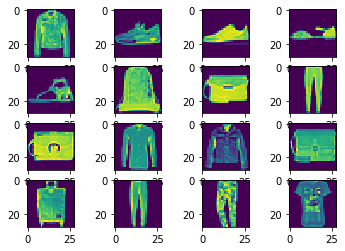

In [5]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(trainxs[np.random.randint(0, len(trainxs))])

## 3.1 Analytical Gradients

Derived them on ipad, i'd rather confirm the results with someone before typing it all out cause it's painful.

## 3.2 Verifying Gradients Correctness

Queue Adam's code here

## 3.3 Implementing the algorithm

In [6]:
# sigmoid for a single sample, preventing overflow
def sigmoid(z):
#     return 1. / (1. + np.exp(-z))
    return np.exp(np.fmin(z, 0)) / (1 + np.exp(-np.abs(z)))

In [7]:
# sigmoid derivative
def sigmoid_d(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [8]:
# forward pass
def forward(params, x):
    x = x.reshape(28**2, 1)
    
    forward_res = {}
    forward_res["z1"] = params["W1"] @ x + params["b1"]
    forward_res["a1"] = sigmoid(forward_res["z1"])
    forward_res["z2"] = params["W2"] @ forward_res["a1"] + params["b2"]
    forward_res["a2"] = sigmoid(forward_res["z2"])
    forward_res["z3"] = params["W3"] @ forward_res["a2"] + params["b3"]
    forward_res["a3"] = sigmoid(forward_res["z3"])
    
    return forward_res

In [9]:
# idk what those are and at this point i'm too scared to ask
def loss(y_pred, y):
    if y_pred == 0 or y_pred == 1:
        return np.array([[0]])
    return (-y * np.log(y_pred)) - ((1 - y) * np.log(1 - y_pred))

def loss_prime(y_pred, y):
    return (-y/y_pred) + (1-y)/(1-y_pred)

In [10]:
# backpropagation
def backprop(x, y, params, forward_res):
    x = x.reshape(28**2, 1)
    
    grads = {}
    
    z1 = params["W1"].dot(x) + params["b1"]
    a1 = sigmoid(z1)
    
    z2 = params["W2"].dot(a1) + params["b2"]
    a2 = sigmoid(z2)
    
    z3 = params["W3"].dot(a2) + params["b3"]
    y_pred = a3 = sigmoid(z3)
    
    dL_dz3 = loss_prime(y_pred, y) * sigmoid_d(z3) # (1, 1)
    dL_dz2 = dL_dz3.dot(params["W3"]).T * sigmoid_d(z2) # (20, 1)
    dL_dz1 = np.multiply(dL_dz2.T.dot(params["W2"]).T, sigmoid_d(z1)) # (200, 1)
    
    grads["dW3"] = dL_dz3.dot(a2.T) # (1, 20) <- not sure those are right didn't check
    grads["db3"] = dL_dz3 # (1, 1)
    
    grads["dW2"] = dL_dz2.dot(a1.T) # (20, 200)
    grads["db2"] = dL_dz2 # (20, 1)
    
    grads["dW1"] = dL_dz1.dot(x.T) # (784, 200)
    grads["db1"] = dL_dz1 # (200, 1)

    return grads

In [11]:
def update_params(grads, params, lr, momentum, dW1, db1, dW2, db2, dW3, db3):
#     I DO NOT KNOW WHAT THIS IS
# THIS IS WITH MOMENTUM BUT I DONT THINK WE NEED IT UWU
    # with momentum (optional)
#     if epoch == 0:
#                dW1 = 0
#                db1 = 0
#                ...
    # use momentum 0 so dW1 = grads["dW1"], db1 = grads["db1"]...
    dW1 = momentum * dW1 + (1 - momentum) * grads["dW1"]
    db1 = momentum * db1 + (1 - momentum) * grads["db1"]
    dW2 = momentum * dW2 + (1 - momentum) * grads["dW2"]
    db2 = momentum * db2 + (1 - momentum) * grads["db2"]
    dW3 = momentum * dW3 + (1 - momentum) * grads["dW3"]
    db3 = momentum * db3 + (1 - momentum) * grads["db3"]

    params["W1"] += (lr * dW1)
    params["b1"] += lr * db1
    params["W2"] += (lr * dW2)
    params["b2"] += lr * db2
    params["W3"] += (lr * dW3)
    params["b3"] += lr * db3
    return params

In [12]:
def update_grads(grads, ups, batch_size):
    grads["dW3"] -= ups["dW3"] / batch_size
    grads["db3"] -= ups["db3"] / batch_size
    
    grads["dW2"] -= ups["dW2"] / batch_size
    grads["db2"] -= ups["db3"] / batch_size
    
    grads["dW1"] -= ups["dW1"] / batch_size
    grads["db1"] -= ups["db1"] / batch_size
    return grads

In [13]:
def mlp(xs, ys, learning_rate, momentum, devxs, devys):
    img_size = 28**2
    h1 = 200
    h2 = 20
    out_size = 1
    
    #     stores training set loss for part 3.5
    loss_training = []
    
    #     stores training set accuracy for part 3.6
    accuracy_training = []
    
    #     stores validation set accuracy for part 3.7
    accuracy_validation = []
    
    # initialise parameters
    params = {"W1": np.random.randn(h1, img_size) * np.sqrt(1 / img_size),
              "b1": np.zeros((h1, 1)),
              "W2": np.random.randn(h2, h1) * np.sqrt(1 / h1),
              "b2": np.zeros((h2, 1)),
              "W3": np.random.randn(out_size, h2) * np.sqrt(1 / h2),
              "b3": np.zeros((out_size, 1))}
    
    grads = {}
    
    loss_old = validation_loss(devxs, devys, params)
    print('loss_old', loss_old)
    
    epoch = 0
    row_epoch = 0
        
    while True:
        # shuffle training set
        permutation = np.random.permutation(xs.shape[0])
        trainxs_shuffled = xs[permutation]
        trainys_shuffled = ys[permutation]
        
        grads["dW3"]  = np.zeros_like(params["W3"])
        grads["db3"] = np.zeros_like(params["b3"])

        grads["dW2"] = np.zeros_like(params["W2"])
        grads["db2"] = np.zeros_like(params["b2"])

        grads["dW1"] = np.zeros_like(params["W1"])
        grads["db1"] = np.zeros_like(params["b1"])
        
        if epoch == 0:
            dW1 = np.zeros_like(params["W1"])
            db1 = np.zeros_like(params["b1"])
            
            dW2 = np.zeros_like(params["W2"])
            db2 = np.zeros_like(params["b2"])
            
            dW3 = np.zeros_like(params["W3"])
            db3 = np.zeros_like(params["b3"])
        
        print("epoch", epoch)
        for i in range (trainxs.shape[0]):
            forward_res = forward(params, trainxs_shuffled[i])
            ups = backprop(trainxs_shuffled[i], trainys_shuffled[i], params, forward_res)
            grads = update_grads(grads, ups, trainxs_shuffled.shape[0])

        params = update_params(grads, params, learning_rate, momentum, dW1, db1, dW2, db2, dW3, db3)
        
        loss_t = validation_loss(xs, ys, params)
        loss_training.append(loss_t)
        
        accuracy_t = accuracy(xs, ys, params)
        accuracy_training.append(accuracy_t)
    
        accuracy_valid = accuracy(devxs, devys, params)
        accuracy_validation.append(accuracy_valid)
        
        loss_valid = validation_loss(devxs, devys, params)
#         print('want loss', log_loss(devys, [predict_mlp(x, params) for x in devxs]))
        print('validation loss', loss_valid)
        print('training accuracy', accuracy_t)
        if np.abs(loss_valid - loss_old) == 0:
            row_epoch += 1
            if row_epoch == 5:
                break
        else:
            row_epoch = 0
        loss_old = loss_valid
        epoch += 1
    return epoch, loss_training, accuracy_training, accuracy_validation

In [14]:
def predict_mlp(x, params):    
    forward_res = forward(params, x)
    if forward_res["a3"] >= 0.5:
        return 1
    return 0

In [15]:
# function to calculate accuracy
def accuracy(devxs, devys, params):
    accuracy = 0
    for i in range (devxs.shape[0]):
        yp = predict_mlp(devxs[i], params)
        if (yp == devys[i]):
            accuracy += 1
    return (accuracy / devys.shape[0]) * 100

In [16]:
# function to determine loss
def validation_loss(devxs, devys, params):
    l = 0
    for i in range (devxs.shape[0]):
        yprime = predict_mlp(devxs[i], params)
        if (yprime == 0 and devys[i] == 1):
            yprime += 1e-15
        elif yprime == 1 and devys[i] == 0:
            yprime -= 1e-15
        if devys[i] == 1:
            l += np.log(yprime)
        else:
            l += np.log(1 - yprime)
    return ((-1) / devys.shape[0]) * l

## 3.4 Training model to convergence

Convergence is defined as no improvement in validation loss over 3 consecutive parameter updates.

In [20]:
# define hyperparameters

# full-batch gradient descent, so not using batch_size as a parameter
learning_rate = 0.4
momentum = 0

In [21]:
# img_size = 28**2
# h1 = 200
# h2 = 20
# out_size = 1

# #     stores training set loss for part 3.5
# loss_training = []

# #     stores training set accuracy for part 3.6
# accuracy_training = []

# #     stores validation set accuracy for part 3.7
# accuracy_validation = []

# # initialise parameters
# params = {"W1": np.random.randn(h1, img_size) * np.sqrt(1 / img_size),
#           "b1": np.zeros((h1, 1)),
#           "W2": np.random.randn(h2, h1) * np.sqrt(1 / h1),
#           "b2": np.zeros((h2, 1)),
#           "W3": np.random.randn(out_size, h2) * np.sqrt(1 / h2),
#           "b3": np.zeros((out_size, 1))}
# validation_loss(devxs, devys, params)

In [22]:
epoch, loss_training, accuracy_training, accuracy_validation = mlp(trainxs, trainys, learning_rate, momentum, devxs, devys)

loss_old 17.09709011620888
epoch 0
validation loss 16.751693556688036
training accuracy 50.84166666666666
epoch 1
validation loss 11.777965028685975
training accuracy 65.875
epoch 2
validation loss 8.842106666518978
training accuracy 73.35833333333333
epoch 3
validation loss 7.909538114725764
training accuracy 76.78333333333333
epoch 4
validation loss 7.218745795281508
training accuracy 78.60833333333333
epoch 5
validation loss 6.838805661781174
training accuracy 79.44166666666666
epoch 6
validation loss 6.666102984234886
training accuracy 79.89166666666667
epoch 7
validation loss 6.700637762642646
training accuracy 80.26666666666667
epoch 8
validation loss 6.493397907896308
training accuracy 80.43333333333334
epoch 9
validation loss 6.28615725355254
training accuracy 80.83333333333333
epoch 10
validation loss 6.078917398806202
training accuracy 81.04166666666667
epoch 11
validation loss 6.0443770232164304
training accuracy 81.33333333333333
epoch 12
validation loss 5.906217919649635
t

## 3.5 Loss plot for training set

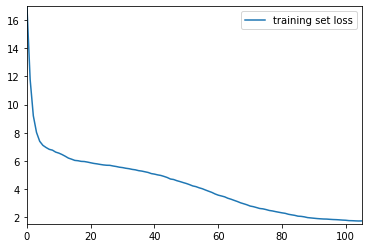

In [27]:
plt.axis([0, epoch, min(loss_training) - 0.2, max(loss_training) + 0.005])
plt.plot(loss_training, label='training set loss')
plt.legend(loc='upper right')

## 3.6 Accuracy plot for training set

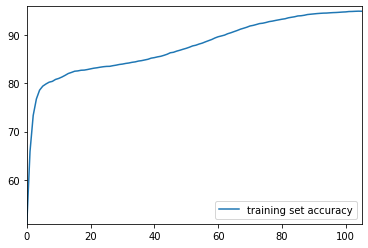

In [24]:
plt.axis([0, epoch, min(accuracy_training), max(accuracy_training) + 1])
plt.plot(accuracy_training, label='training set accuracy')
plt.legend(loc='lower right')

## 3.7 Accuracy for best epoch

In [28]:
ind = accuracy_validation.index(max(accuracy_validation))

In [29]:
print("Best epoch =", ind)
print("Accuracy on training set =", accuracy_training[ind])
print("Accuracy on validation set =", accuracy_validation[ind])

Best epoch = 96
Accuracy on training set = 94.71666666666667
Accuracy on validation set = 95.5
